In [1]:
# 평가 이미지 리스트
BASE_DIR = '/data/kts123/aihub/reid'
test_imgs = '/data/kts123/aihub/reid/img_list_test.txt'

# 훈련된 모델경로
weight_path = '/home/kts123/gc2021/3차/track3/arcface/checkpoints_res50_base/scheduler_resnet50_99.pth'

In [2]:
# 평가용 데이터셋
from data import dataset
ds = dataset.DataSet(BASE_DIR, test_imgs, phase='test')

In [3]:
# 평가용 데이터로더 생성
from torch.utils.data import DataLoader
dl = DataLoader(ds, num_workers=4, batch_size=32)

torch.Size([3, 224, 224])


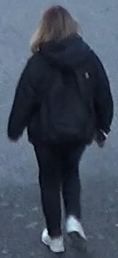

In [4]:
# 샘플 이미지 출력
from PIL import Image
im, kls, path = ds[2]
print(im.shape)
Image.open(path)

In [5]:
# 모델 로드
def load_model(model, model_path):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path)
    pretrained_dict = {k:v for k, v in pretrained_dict.items() if k in model_dict}
    no_model_keys = [k for k, _ in pretrained_dict.items() if k in model_dict]
    print('no_model_keys:', no_model_keys)

    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


In [6]:
# 정확도 계산 유틸 함수
def cal_accuracy(y_score, y_true):
    y_score = np.asarray(y_score)
    y_true = np.asarray(y_true)
    best_acc = 0
    best_th = 0
    for i in range(len(y_score)):
        th = y_score[i]
        y_test = (y_score > th)
        acc = np.mean((y_test == y_true).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_th = th

    return (best_acc, best_th)

In [8]:
# 학습된 모델 불러오기
import torch
from models import resnet50

model = resnet50()
model = load_model(model, weight_path)
model = model.to('cuda')

load pretrained model
no_model_keys: []


In [ ]:
# inference
from tqdm.auto import tqdm
ds = dataset.DataSet(BASE_DIR, test_imgs, phase='test')
dl = DataLoader(ds, num_workers=4, batch_size=16)
print(len(ds), len(dl))

# 임베딩값
total_outs = []

# 대응되는 경로
total_paths = []

# 대등되는 클래스 아이디
total_klss = []
for i, (ims, klss, paths) in enumerate(tqdm(dl)):
    ims = ims.to('cuda')
    outs = model(ims).detach()
    total_outs.append(outs)
    total_paths.extend(paths)
    total_klss.append(klss)
    if 1 < i:
        break
print(len(total_outs))
print(len(total_paths))
print(outs.shape)
print(ims.mean(), ims.std())